In [1]:
## classification algo

## THINGS TRIED:
# 1. 3-class classification with SVC & RF


import pandas as pd
import numpy as np
import os
import pickle
from scipy import stats
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.metrics import auc,accuracy_score
from sklearn.metrics import precision_recall_fscore_support,confusion_matrix

from datetime import datetime

In [2]:
######################  functions #########################

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


#################################################################################

In [3]:
#################################################################################################################

### using individual epoch data ###

In [4]:
file_location='C:\\Users\\Desktop\\data\\HEALTHCARE\\EEG\\data\\Pickle_Files_6nov2018'
os.chdir('C:\\Users\\Desktop\\data\\HEALTHCARE\\EEG\\data\\Pickle_Files_6nov2018') 


In [5]:
# remove xls for 2nd night of subject 13, as there was data loss 
# read in all xls, & then the sheets

dfull = pickle.load(open('dfull_6nov.pkl', 'rb'))

In [6]:
dfull.head(2)

,pat_id,day,segment,epoch,delta,theta,alpha,beta,gamma,class
0,400,1,Seg1,1,0.703302,0.146348,0.099262,0.037832,0.018150,wake
1,400,1,Seg1,2,0.580056,0.166110,0.089898,0.058965,0.049103,wake


In [7]:
dfull.groupby('class').agg({'delta': 'count'})

,delta
class,
sleep_stage_1,2804
sleep_stage_2,17799
wake,72391


In [8]:
dfull.groupby(['pat_id','class']).agg({'delta': 'count'})

delta
pat_id class               
400    sleep_stage_1    117
       sleep_stage_2    623
       wake            3882
401    sleep_stage_1    201
       sleep_stage_2   1222
       wake            3680
402    sleep_stage_1    278
       sleep_stage_2    947
       wake            3778
403    sleep_stage_1    106
       sleep_stage_2    885
       wake            3965
404    sleep_stage_1    303
       sleep_stage_2   1134
       wake            3307
405    sleep_stage_1    158
       sleep_stage_2    833
       wake            4038
406    sleep_stage_1    146
       sleep_stage_2    824
       wake            4076
407    sleep_stage_1    173
       sleep_stage_2    795
       wake            3862
408    sleep_stage_1    107
       sleep_stage_2    591
       wake            3709
409    sleep_stage_1    100
       sleep_stage_2   1073
       wake            2818
410    sleep_stage_1    182
       sleep_stage_2   1278
       wake            3679
411    sleep_stage_1     31
       sleep_stage_2    898
       wake            3943
412    sleep_stage_1    169
       sleep_stage_2    750
       wake            3728
413    sleep_stage_1     57
       sleep_stage_2    497
       wake            1941
414    sleep_stage_1     56
       sleep_stage_2    790
       wake            3942
415    sleep_stage_1     88
       sleep_stage_2    792
       wake            3740
416    sleep_stage_1     97
       sleep_stage_2    907
       wake            3619
417    sleep_stage_1     65
       sleep_stage_2   1015
       wake            3551
418    sleep_stage_1    180
       sleep_stage_2    678
       wake            3999
419    sleep_stage_1    190
       sleep_stage_2   1267
       wake            3134

In [9]:
dfull['class2'] = dfull['class']
dfull['class2'] = [0 if x == 'wake' else 1 if x == 'sleep_stage_1' else 2 for x in dfull['class2']]

In [10]:
dfull.dtypes

pat_id      object
day         object
segment     object
epoch       object
delta      float64
theta      float64
alpha      float64
beta       float64
gamma      float64
class       object
class2       int64
dtype: object

In [11]:
## convert selected columns to categories 
dfull[['class']] = dfull[['class']].astype('str') 
dfull[['class']] = dfull[['class']].astype('category')

In [12]:
### create a smaller subset of data for testing algo
dw = dfull[(dfull['class'] == 'wake')]
d1 = dfull[(dfull['class'] == 'sleep_stage_1')]
d2 = dfull[(dfull['class'] == 'sleep_stage_2')]

# https://stackoverflow.com/questions/15923826/random-row-selection-in-pandas-dataframe
# Randomly sample n elements from your dataframe
d1_elements = d1.sample(n=2800)
d2_elements = d2.sample(n=2800)
dw_elements = dw.sample(n=2800)

dn = pd.DataFrame()
dn = pd.concat([dw_elements, d1_elements, d2_elements],ignore_index=True)
dn.shape[0]

8400

In [13]:
## create train-test data
X = dn[['delta','theta','alpha','beta','gamma']]  # dfull[['delta','theta','alpha','beta','gamma']]
y = dn[['class']]  # dfull[['class']] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


## normalize the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

X_train_scaled.shape

(6720, 5)

In [ ]:
#### SVC MODEL ####

In [14]:
datetime.now().strftime('%Y-%m-%d %H:%M:%S')

'2018-11-07 10:03:19'

In [15]:
## fit model - vary ML algo & hyperparameters

model_svc = SVC()  # kernel='linear'
model_svc.fit(X_train_scaled, y_train)

C:\Users\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [16]:
datetime.now().strftime('%Y-%m-%d %H:%M:%S')

'2018-11-07 10:03:21'

In [17]:
# predict on test data - check metrics
y_pred = model_svc.predict(X_test_scaled)

Confusion matrix, without normalization
[[296 105 145]
 [ 70 354 134]
 [ 54  15 507]]
Normalized confusion matrix
[[0.54 0.19 0.27]
 [0.13 0.63 0.24]
 [0.09 0.03 0.88]]


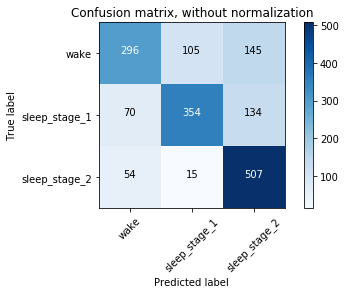

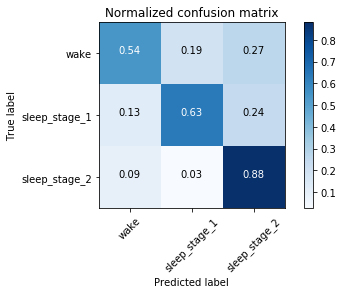

In [18]:
####    Compute confusion matrix     ####

class_names = ['wake','sleep_stage_1','sleep_stage_2']  # wake, SS1, SS2  ; # '0','1','2'

cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix : normalisation shows nan for class'0' no signal has class=0 as true label
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [19]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=class_names))

               precision    recall  f1-score   support

         wake       0.70      0.54      0.61       546
sleep_stage_1       0.75      0.63      0.69       558
sleep_stage_2       0.65      0.88      0.74       576

  avg / total       0.70      0.69      0.68      1680



In [20]:
Ts = pd.DataFrame()
Ts['class_act'] = y_test['class']
Ts['class_pred'] = y_pred
Ts.head(2)

,class_act,class_pred
2876,sleep_stage_1,sleep_stage_1
3281,sleep_stage_1,sleep_stage_2


In [21]:
Ts.groupby('class_act').size()

class_act
sleep_stage_1    546
sleep_stage_2    558
wake             576
dtype: int64

In [22]:
Ts.groupby('class_pred').size()

class_pred
sleep_stage_1    420
sleep_stage_2    474
wake             786
dtype: int64

In [ ]:
### comment: although the row counts are correct, the labels are not correct in the confusion matrix

In [ ]:
#### RF model ####

In [23]:
datetime.now().strftime('%Y-%m-%d %H:%M:%S')

'2018-11-07 12:04:34'

In [24]:
model_rf = RandomForestClassifier(n_estimators = 501) ## max_depth=5, random_state=0,verbose =0)  
# max_features=2, min_samples_split=4, n_estimators=50, min_samples_leaf=2
model_rf.fit(X_train_scaled, y_train)

C:\Users\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=501, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [25]:
datetime.now().strftime('%Y-%m-%d %H:%M:%S')

'2018-11-07 12:04:42'

In [26]:
# predict on test data - check metrics
y_pred = model_rf.predict(X_test_scaled)

In [27]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=class_names))

               precision    recall  f1-score   support

         wake       0.69      0.63      0.66       546
sleep_stage_1       0.75      0.78      0.76       558
sleep_stage_2       0.78      0.82      0.80       576

  avg / total       0.74      0.74      0.74      1680



Confusion matrix, without normalization
[[346 117  83]
 [ 76 435  47]
 [ 78  28 470]]
Normalized confusion matrix
[[0.63 0.21 0.15]
 [0.14 0.78 0.08]
 [0.14 0.05 0.82]]


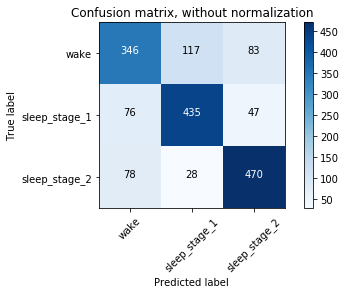

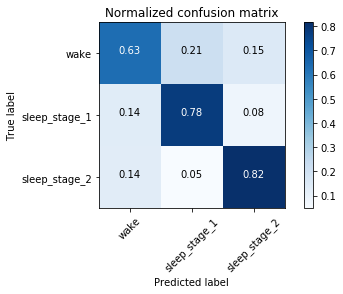

In [28]:
####    Compute confusion matrix     ####

class_names = ['wake','sleep_stage_1','sleep_stage_2']  # wake, SS1, SS2  ; # '0','1','2'

cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix : normalisation shows nan for class'0' no signal has class=0 as true label
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [29]:
Ts = pd.DataFrame()
Ts['class_act'] = y_test['class']
Ts['class_pred'] = y_pred
Ts.head(2)

,class_act,class_pred
2876,sleep_stage_1,sleep_stage_1
3281,sleep_stage_1,sleep_stage_2


In [30]:
Ts.groupby('class_act').size()

class_act
sleep_stage_1    546
sleep_stage_2    558
wake             576
dtype: int64

In [31]:
Ts.groupby('class_pred').size()

class_pred
sleep_stage_1    500
sleep_stage_2    580
wake             600
dtype: int64

Confusion matrix, without normalization
[[346 117  83]
 [ 76 435  47]
 [ 78  28 470]]
Normalized confusion matrix
[[0.63 0.21 0.15]
 [0.14 0.78 0.08]
 [0.14 0.05 0.82]]


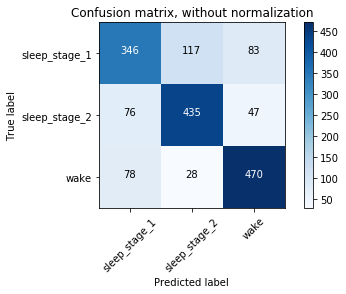

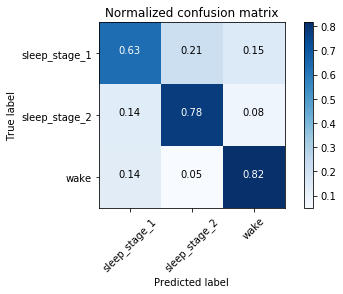

In [32]:
## in class names, use the same order as in output of groupby 
class_names = ['sleep_stage_1','sleep_stage_2','wake']  # wake, SS1, SS2  ; # '0','1','2'

cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix : normalisation shows nan for class'0' no signal has class=0 as true label
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [38]:
print(classification_report(y_test, y_pred, target_names=class_names))
# 0 corrs to SS1,  1 : SS2  &  3: wake

             precision    recall  f1-score   support

          0       0.69      0.63      0.66       546
          1       0.75      0.78      0.76       558
          2       0.78      0.82      0.80       576

avg / total       0.74      0.74      0.74      1680



In [ ]:
## change the classification from wake, SS1 etc to 0,1, 2 & check precision,recall

In [33]:
Ts['class_act'] = ['0' if x == 'wake' else '1' if x == 'sleep_stage_1' else '2' for x in Ts['class_act']]
Ts['class_pred'] = ['0' if x == 'wake' else '1' if x == 'sleep_stage_1' else '2' for x in Ts['class_pred']]

In [34]:
Ts.groupby('class_act').size()

class_act
0    576
1    546
2    558
dtype: int64

In [35]:
Ts.groupby('class_pred').size()

class_pred
0    600
1    500
2    580
dtype: int64

In [36]:
## from RF model
class_names = ['0','1','2']
ytest = Ts['class_act']
ypred = Ts['class_pred']
print(classification_report(ytest, ypred, target_names=class_names))

             precision    recall  f1-score   support

          0       0.78      0.82      0.80       576
          1       0.69      0.63      0.66       546
          2       0.75      0.78      0.76       558

avg / total       0.74      0.74      0.74      1680



Confusion matrix, without normalization
[[470  78  28]
 [ 83 346 117]
 [ 47  76 435]]
Normalized confusion matrix
[[0.82 0.14 0.05]
 [0.15 0.63 0.21]
 [0.08 0.14 0.78]]


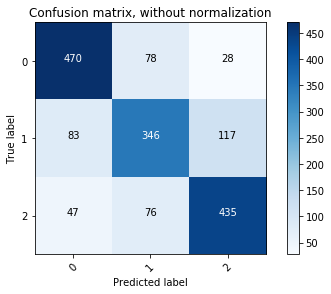

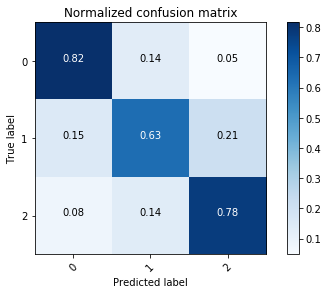

In [37]:
## in class names, use the same order as in output of groupby 
class_names = ['0','1','2']  # wake, SS1, SS2  ; # '0','1','2'

cnf_matrix = confusion_matrix(ytest, ypred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix : normalisation shows nan for class'0' no signal has class=0 as true label
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [40]:
## save the training & test sets

Train = pd.concat([X_train,y_train],axis=1)
Train.to_excel("C:\\Users\\Desktop\\data\\HEALTHCARE\\EEG\\data\\training_data_3stage.xlsx")

Train.head(5)

,delta,theta,alpha,beta,gamma,class
2586,0.550596,0.176619,0.131146,0.078002,0.032223,wake
5467,0.461529,0.167010,0.148383,0.116500,0.065478,sleep_stage_1
4576,0.678690,0.107442,0.066313,0.056259,0.045225,sleep_stage_1
5766,0.423911,0.202512,0.138790,0.131020,0.070190,sleep_stage_2
6751,0.610648,0.234870,0.098794,0.040527,0.016132,sleep_stage_2


In [41]:
Test = pd.concat([X_test,y_test],axis=1)
Test.to_excel("C:\\Users\\Desktop\\data\\HEALTHCARE\\EEG\\data\\test_data_3stage.xlsx")

Test.head(5)

,delta,theta,alpha,beta,gamma,class
2876,0.493560,0.102239,0.102969,0.096628,0.115924,sleep_stage_1
3281,0.532330,0.188965,0.132549,0.078836,0.041364,sleep_stage_1
2631,0.583887,0.120817,0.075969,0.065158,0.070059,wake
1837,0.397956,0.303622,0.151444,0.077125,0.047845,wake
3535,0.642075,0.093682,0.088097,0.093259,0.051846,sleep_stage_1


In [42]:
Train.groupby('class').agg({'delta': 'count'})

,delta
class,
sleep_stage_1,2254
sleep_stage_2,2242
wake,2224


In [43]:
Test.groupby('class').agg({'delta': 'count'})

,delta
class,
sleep_stage_1,546
sleep_stage_2,558
wake,576


In [ ]:
########################################################################################

## using the class labels as numeric

In [44]:
Ts.dtypes

class_act     object
class_pred    object
dtype: object

In [48]:
Ts[['class_act','class_pred']] = Ts[['class_act','class_pred']].astype(int)
Ts.dtypes

class_act     int32
class_pred    int32
dtype: object

In [49]:
## from RF model
class_names = [0,1,2]
ytest = Ts['class_act']
ypred = Ts['class_pred']
print(classification_report(ytest, ypred, target_names=class_names))

TypeError: object of type 'int' has no len()

Confusion matrix, without normalization
[[470  78  28]
 [ 83 346 117]
 [ 47  76 435]]


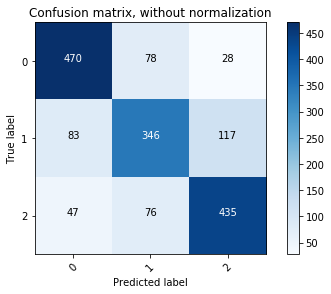

In [50]:
cnf_matrix = confusion_matrix(ytest, ypred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')


In [51]:
Ts['class_act'] = [0 if x == '0' else 1 if x == '1' else 2 for x in Ts['class_act']]
Ts['class_pred'] = [0 if x == '0' else 1 if x == '1' else 2 for x in Ts['class_pred']]

In [54]:
Ts.dtypes

class_act     int64
class_pred    int64
dtype: object

In [53]:
## from RF model
class_names = ['0','1','2']
ytest = Ts['class_act']
ypred = Ts['class_pred']
print(classification_report(ytest, ypred, target_names=class_names))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1680

avg / total       1.00      1.00      1.00      1680



C:\Users\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 1, does not match size of target_names, 3
  .format(len(labels), len(target_names))
